# Uso básico de TEN

Podemos utilizar TEN de dos maneras distintas. La primera, es simplemente usar el main.py y la segunda es llamando a cada módulo desde una terminal python (IPython en este caso).

## Mediante cli
El uso de *TEN* mediante la *cli* consta de dos archivos. El primero es el archivo de configuración de la simulación (*experiment.conf* por default). En este archivo vamos a setear las propiedades de la NP y los dopantes, la forma de generación de los exitones y demas parámetros de la simulación.
*experiment.conf* tiene esta forma:

    """
    Configuration of the experiment.

    NP Parameters
    -------------
    r_mean : float
        Mean of the normal distribution nanoparticle radius. [r] = nm
    r_deviation : float, optional
        Standard deviation of the normal distribution NP radius. 
        if not, the radius is considered constant. [r] = nm
    R_Forster : float
        Forster radius. [R_Forster] = nm
    mean_path : float
        Mean free path. [mean_path] = nm
    tau_D : float
        Lifetime of donor. [tau_D] = ns
    epsilon : float
        [epsilon] = nm

    Simulation Parameters
    ---------------------
    num_acceptors_min : int, optional
        Minimum number of acceptores to simulate. Default value = 1
    num_acceptors_max : int
        Maximum number of acceptores to simulate.
    acceptors_step : int
        Step number of acceptores.
    num_exc : int
        Numbers of exitation of the same nanoparticle.
    each : bool, optional
        If True in each new recalculation, new positions of dopants is generated.
        Else, only generate one time the dopants.

    Experiment Parameters
    ---------------------
    acceptors : str
        Way to create the acceptors. Can be 'vol' (volumetrically) 
        for uniform distribution inside of nanoparticle or 'sup' (superficialy)
        for uniform distributions on the surface of the nanoparticle.
    exiton : str
        Way to create the exiton. Can be 'laser' to generate uniformily in 
        the nanoparticle or 'elec' (electrolysis) to generate between the 
        radius R of the nanoparticle and a r (R > r).
    r_electro : float, optional
        In a chemical electrolysis, the exiton position is generated between
        the radius R of the nanoparticle and a radius r (r<R),
        where r depends electrolysis.
    """

    r_mean = 15 #coment
    R_Forster = 3.14
    mean_path = 100
    tau_D = 0.333
    epsilon = 1.5

    num_acceptors_min = 0
    num_acceptors_max = 501
    acceptors_step = 20
    num_exc = 2000

    acceptors = vol
    exiton = laser
    r_electro = 0
    
Notar que todas las lineas que estan entre *"""* (triple comilla) y *"""* o las lineas que tienen un *#* son comentarios.

El segundo archivo es *main.py*. Este es el encargado de realizar la simulación.

    ten$ python3 main.py -h
    usage: main.py [-h] [-c CONFIG] [-o OUT_PATH]

    TEN

    optional arguments:
      -h, --help     show this help message and exit
      -c, --config   path to configuration (initial parameters) file
      -o             output path
      
Luego, para usar *TEN* desde la *cli*, simplemente hacemos:

    ten$ python3 main.py
    
Tambien existe un *parallelized_main.py* que, como lo indica su nombre, es la verción paralelizada. 

    ten$ mpirun -np N python3 parallelized_main.py
    
Donde *N* indica la cantidad de procesadores que vamos a usar.

## Llamando a cada módulo

In [2]:
# Imports básicos
import time
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import ten

Podemos usar el mismo archivo de configuración que en el ejempo anterior. Para esto usamos el modulo *read4file*

In [3]:
init_param = ten.read4file('../experiment.conf')

Inicializamos la NP con dopamiento superficial ('sup') y el exiton.

In [ ]:
ten.Nanoparticle

In [5]:
# Dopantes propios (intrisicos) de la NP
dopantes_propios = ten.Aceptor(number=10, r_forster=1, way='vol')
# Dopantes que le vamos a agregar a la NP
dopantes = ten.Aceptor(number=50, r_forster=init_param['R_Forster'], way='vol')

# Nanoparticula
r = [init_param['r_mean'], init_param['r_deviation']]
NP = ten.Nanoparticle(r, init_param['tau_D'], init_param['mean_path'], 
                      init_param['epsilon'], dopantes_propios)

print(NP)

# Dopamos la NP
NP.doped(dopantes)

Radio: 15.0 ~ U(15.0, 0),
Tau: 0.333, Mean_path: 100.0, Epsilon: 1.5,
Delta_t: 0.004995, Prob decay: 0.014888060396937353,
Nº Intrisic aceptors: 10, R_Forster: 1, way: vol


Calculamos la eficiencia de Quenching

In [6]:
out = ten.experiments.quenching(NP, dopantes, ten.mechanisms.forster, 'laser')
print("Eficiencia: {0}, Nº decaidos: {1}, Nº transferidos: {2}".format(out[0], out[1], out[3]-out[1]))
print("Pasos promedio: {0:.2f} nm, Tiempo total: {1:.2f} seg.".format(out[2], out[4]))

Eficiencia: 0.7353333333333333, Nº decaidos: 397, Nº transferidos: 1103
Pasos promedio: 18.33 nm, Tiempo total: 4.75 seg.


### Varias simulaciones de una NP

In [9]:
times = []
eff = []

for i in range(200, 20001, 200):
    simu = ten.Exciton(nano_particle, i, 'laser')
    simu.quenching()
    times.append(simu.total_time)
    eff.append(simu.efficiency)

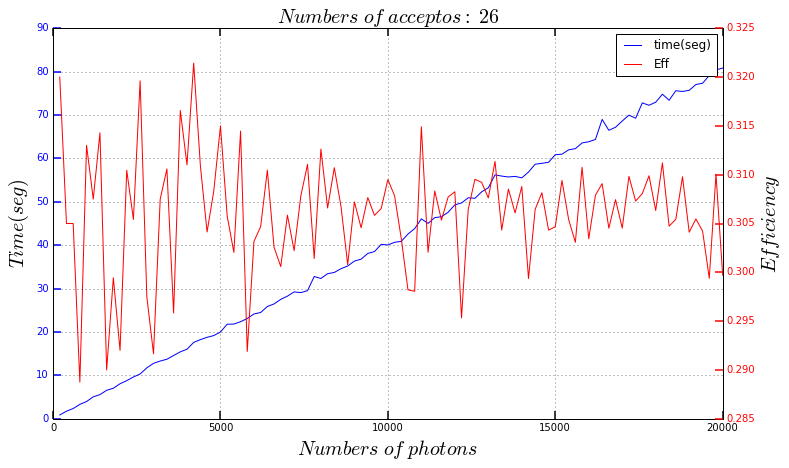

In [13]:
x = np.array(range(200,20001, 200))

fig, host = plt.subplots(figsize=(12,7))

par1 = host.twinx()

p1, = host.plot(x, times, "b-", label="time(seg)")
p2, = par1.plot(x, eff, "r-", label="Eff")

host.set_xlabel(r"$Numbers\; of\; photons$", fontsize=20)
host.set_ylabel(r"$Time(seg)$", fontsize=20)
par1.set_ylabel(r"$Efficiency$", fontsize=20)

tkw = dict(size=8, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2]
host.legend(lines, [l.get_label() for l in lines])

host.grid(True)
plt.title(r'$Numbers\; of\; acceptos:\; %i$' %(simu.nano_particle.n_acceptors), fontsize=20)

Observar que si bien parece que la eficiencia fluctua mucho, las variaciones con $\pm0.01$

In [7]:
#Este css esta basado en el de @LorenaABarba y su grupo
from IPython.core.display import HTML
css_file = 'css/personal.css'
HTML(open(css_file, "r").read())

##### Licencia
El código esta licenciado bajo MIT.

La documentación bajo:
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">TEN</span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Laboratorio de Microscopia Óptica Avanzada - UNRC</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/pewen/ten" rel="dct:source">https://github.com/pewen/ten</a>